# LIBRARIES IMPORT

In [1]:
# imports

import fig_lib 
import CNN_lib
import CNN_utilities
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import json




In [2]:
init_time = time.time()

In [3]:

generate_new_peakle=True
max_frames_allowed=40

data_augmentation= False
number_new_d=150

json_fix_sq_p='C:\PROJECTS\emboendo\dicom_viewer\_static\Jsons\points_fix_d.json'
pkl_d_p = 'C:\PROJECTS\emboendo\CNN/pikles/input_d_processed.pkl'
pkl_train_p='C:\PROJECTS\emboendo\CNN\pikles/processed_train_d.pkl'   



# DATA LOAD

### PROCESSED IMAGES

In [4]:

with open(json_fix_sq_p, 'r') as json_file:
    json_d = json.load(json_file)
    


In [5]:

patients_recs_d_df=CNN_utilities.main_d_df()
patients_labels_d_df=CNN_utilities.labels_df()
patients_d_df=pd.merge( patients_labels_d_df,patients_recs_d_df, on='PatientID')

def find_recs(row):

    rec_true = [record for record in row['Records'] if record in list(json_d.keys())]

    return pd.Series({'recs_crop': rec_true})

new_col = patients_d_df.apply(find_recs, axis=1)
patients_d_df = pd.concat([patients_d_df, new_col], axis=1)
patients_d_df=patients_d_df.drop('Records', axis=1)
patients_d_df =  patients_d_df[patients_d_df['recs_crop'].apply(lambda x: x != [])]

display(patients_d_df)


,PatientID,Sex,Age,S.E.,M.A.,A.C.V.,label,recs_crop
0,62,0,67,0,0,0,0,"[I1, I11, I2, I9]"
1,76,1,72,0,0,0,0,"[I28, I33, I38, I39, I40, I42, I44, I45, I47, ..."
2,93,0,78,0,0,0,0,"[I51, I53, I54, I56, I57, I58, I61, I63, I64, ..."
3,103,0,82,1,0,0,1,"[I70, I71, I72, I73]"
4,105,1,57,1,0,0,1,"[I101, I102, I103, I86, I87, I89, I90, I91, I9..."
...,...,...,...,...,...,...,...,...
82,109897,1,79,0,0,0,0,"[109897_1, 109897_2, 109897_3, 109897_4, 10989..."
83,669183,1,78,0,0,1,1,"[669183_1, 669183_10, 669183_2, 669183_3, 6691..."
84,670615,1,80,1,0,2,1,"[670615_10, 670615_13, 670615_14, 670615_15, 6..."
85,224436,1,77,0,0,0,0,"[224436_1, 224436_10, 224436_11, 224436_12, 22..."


In [6]:
  
tot_recs=sum(len(records) for records in patients_d_df['recs_crop'])
filtered_df_0,filtered_df_1 = patients_d_df[patients_d_df['label'] == 0],patients_d_df[patients_d_df['label'] == 1]
label_0,label_1 = sum(len(records) for records in filtered_df_0['recs_crop']),sum(len(records) for records in filtered_df_1['recs_crop'])

print(f'- PATIENTS: {patients_d_df.shape[0]} ,PATIENT LABEL 0: {sum(patients_d_df["label"]==0)}, PATIENT LABEL 1: {sum(patients_d_df["label"]==1)}')
print( f'- RECORDS: {tot_recs} , RECORDS LABEL 0: {label_0}, RECORDS LABEL 1:{label_1}')
print(f'- RATIO LABEL 0: {np.round(label_0/sum(patients_d_df["label"]==0),decimals=2)}, RATIO LABEL 1: {np.round(label_1/sum(patients_d_df["label"]==1),decimals=2)}')


- PATIENTS: 87 ,PATIENT LABEL 0: 63, PATIENT LABEL 1: 24
- RECORDS: 660 , RECORDS LABEL 0: 485, RECORDS LABEL 1:175
- RATIO LABEL 0: 7.7, RATIO LABEL 1: 7.29


In [7]:
if generate_new_peakle:
    
    input_d={}    

    for label,ii in zip(patients_d_df['label'],patients_d_df['recs_crop']):
        
        for rec in ii:

            input_d[rec]={'label':label}
            vd_ls=[]

            for i in range(len(json_d[rec])):
                
                if i== max_frames_allowed: break
                
                else:
                    try:
                        image_8bit=np.load(json_d[rec][str(i)]['cropped_image'])
                        #print(rec,label,i, np.shape(image_8bit))
                        width=np.shape(image_8bit)[0]
                        height = np.shape(image_8bit)[1]
                        vd_ls.append(image_8bit)
                    except:pass
                
            input_d[rec]['image']=np.array(vd_ls)
            input_d[rec]['dimHW']= [height,width]   
    
    with open(pkl_d_p, 'wb') as pikle_file:
        
        pickle.dump(input_d, pikle_file)

else: 

    with open(pkl_d_p, 'rb') as pikle_file:
        input_d = pickle.load(pikle_file)

# CHECK DATA

In [8]:
print('RECORD - LABEL - SHAPE')

#if d_type== 'synthetic':
    
for R in input_d.keys():
    print(R,input_d[R]['label'],np.shape(input_d[R]['image']),type(input_d[R]['image']))

RECORD - LABEL - SHAPE
I1 0 (40, 150, 150) <class 'numpy.ndarray'>
I11 0 (40, 160, 160) <class 'numpy.ndarray'>
I2 0 (40, 140, 140) <class 'numpy.ndarray'>
I9 0 (40, 150, 150) <class 'numpy.ndarray'>
I28 0 (23, 130, 130) <class 'numpy.ndarray'>
I33 0 (24, 130, 130) <class 'numpy.ndarray'>
I38 0 (24, 150, 150) <class 'numpy.ndarray'>
I39 0 (24, 130, 130) <class 'numpy.ndarray'>
I40 0 (20, 140, 140) <class 'numpy.ndarray'>
I42 0 (22, 140, 140) <class 'numpy.ndarray'>
I44 0 (23, 140, 140) <class 'numpy.ndarray'>
I45 0 (24, 140, 140) <class 'numpy.ndarray'>
I47 0 (23, 140, 140) <class 'numpy.ndarray'>
I49 0 (23, 140, 140) <class 'numpy.ndarray'>
I51 0 (39, 150, 150) <class 'numpy.ndarray'>
I53 0 (39, 150, 150) <class 'numpy.ndarray'>
I54 0 (39, 150, 150) <class 'numpy.ndarray'>
I56 0 (39, 150, 150) <class 'numpy.ndarray'>
I57 0 (39, 150, 150) <class 'numpy.ndarray'>
I58 0 (39, 150, 150) <class 'numpy.ndarray'>
I61 0 (39, 150, 150) <class 'numpy.ndarray'>
I63 0 (39, 150, 150) <class 'numpy.

In [9]:
d_plt_check,rec_check=True,'I70'
t_btw_frm=0.05
print(input_d[rec_check]['label'])


1


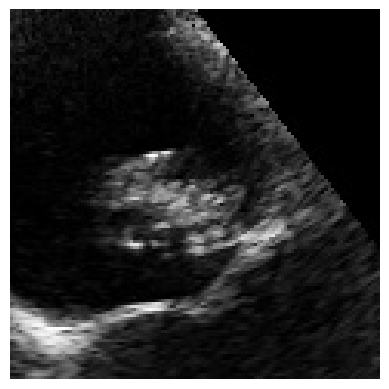

In [10]:
# check video

if d_plt_check:fig_lib.vid_show(input_d[rec_check]['image'],t_btw_frm=t_btw_frm)
    

# GENERATE TRAIN DATA

In [11]:
# X_train,Y_train

X_train,Y_train,max_frm_n,HEIGHT, WIDTH =CNN_lib.vid_d_bin_gen(input_d, zero=0, one= 1,pad_type='loop',im_pad_type='center')
recs=list(input_d.keys())


# DATA AUGMENTATION

In [12]:
if data_augmentation:

    aug_recs=[]
    aug_X_train=[]
    aug_Y_train=np.ones(number_new_d)

    idx_Y_1 = np.where(Y_train == 1)[0]
    idx_Y_1 = np.random.choice(idx_Y_1, size=number_new_d, replace=False)

    for index in idx_Y_1:

        video=CNN_lib.random_flip(X_train[index])
        aug_X_train.append(video)
        aug_recs.append('AUG_'+recs[index])

    aug_X_train=np.array(aug_X_train)
    
    


In [13]:
if data_augmentation:

    Y_train = np.concatenate((Y_train, aug_Y_train))
    X_train=np.concatenate((X_train, aug_X_train), axis=0)
    recs=recs+aug_recs

In [14]:
#video = tf.image.random_brightness(video, max_delta=0.9)    # OK
#video = tf.image.random_contrast(video, lower=0.5, upper=10)   # OK

### SAVE DATA

In [15]:
save_trains=[X_train,Y_train,recs]
with open(pkl_train_p, 'wb') as pikle_file:
        
        pickle.dump(save_trains, pikle_file)


In [16]:
end_time = time.time()

process_time = end_time - init_time
print(f"Tiempo transcurrido: {process_time} segundos")

Tiempo transcurrido: 13.147496938705444 segundos


### CHECK SAVED DATA

In [17]:
with open(pkl_train_p, 'rb') as pikle_file:

    save_trains= pickle.load(pikle_file)

x_train,y_train =  save_trains[0],save_trains[1]
recs=save_trains[2]

In [18]:
print(type(x_train),type(y_train),type(recs))
print(x_train.shape,y_train.shape,len(recs))
print(np.max(x_train))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'list'>
(810, 40, 160, 160, 1) (810,) 810
1.0


In [19]:
rec_elm='I70'
idx=recs.index(rec_elm)
Y_train[idx]

1.0

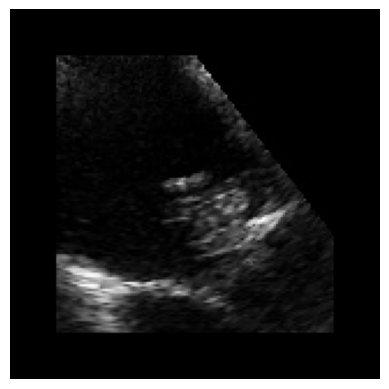

In [20]:
fig_lib.vid_show(X_train[idx],t_btw_frm=t_btw_frm)